Example with Temperature and Environmental Policies

https://towardsdatascience.com/a-recipe-to-empirically-answer-any-question-quickly-22e48c867dd5

1. Variables selection

Central aspect: Climate change is a global, long-lasting, relatively low pace phenomenon. Hence, the effect of heat waves on climate-change laws is arguably causal (e.g. the behavior of France in 2020 is not expected to affect the average temperature the same year or the year after).

outcome: Environmental policies,
explanatory variable: Average yearly temperature,
additional explanatory variable: Heat-waves might be aggravated if rainfall is low, hence I will also add average yearly rainfall.
This is the minimal ingredient list I would select: an outcome, an explanatory variable, and a third variable to explore the potential heterogeneity of the effect (here rainfall).

2. Sample selection

- cname: Country name
- year: Year
- oecd_eps: Environmental Policy Stringency Index² (from Botta and Kozluk (2014))
- cckp_temp: Annual average temperature in Celsius³ (from the Climate Change Knowledge Portal)
- cckp_rain: Annual average rainfall in mm³ (from the Climate Change Knowledge Portal)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import numpy as np
import plotly.express as px
#import data from the Quality of Government Environmental Indicators Dataset
df = pd.read_excel('https://www.qogdata.pol.gu.se/data/qog_ei_sept21.xlsx')
#select a subset of variables
df = df[['cname', 'ccodealp', 'year', 'oecd_eps', 'cckp_temp', 'cckp_rain']]
df.describe()

,year,oecd_eps,cckp_temp,cckp_rain
count,11722.000000,799.000000,11135.000000,11135.000000
mean,1988.188193,1.567856,19.009990,100.390635
std,20.252364,0.960634,8.123073,71.011072
min,1946.000000,0.208333,-9.216667,1.166667
25%,1972.000000,0.687500,11.691667,46.045833
50%,1990.000000,1.354167,22.416667,86.850000
75%,2005.000000,2.262500,25.466667,144.287500
max,2020.000000,4.133333,29.366667,417.391667


In [2]:
# Show the number of observations by year where 'oecd_eps' variable is not null
df[pd.notnull(df['oecd_eps'])].groupby(['year']).size().reset_index(name='counts')

,year,counts
0,1990,28
1,1991,28
2,1992,29
3,1993,32
4,1994,32
5,1995,33
6,1996,33
7,1997,33
8,1998,33
9,1999,33


In [3]:
# Selecting the sub sample
df_s = df[pd.notnull(df['oecd_eps']) & (df['year'] >= 1993) & (df['year'] <= 2012)]
df_s.describe()

,year,oecd_eps,cckp_temp,cckp_rain
count,663.000000,663.000000,663.000000,663.000000
mean,2002.583710,1.606863,10.686664,76.825842
std,5.773822,0.940719,7.445290,41.994952
min,1993.000000,0.333333,-7.433333,28.183333
25%,1998.000000,0.750000,7.458333,49.870833
50%,2003.000000,1.479167,10.141667,63.166667
75%,2008.000000,2.333333,13.729167,92.204167
max,2012.000000,4.133333,26.375000,281.100000


In [4]:
#Final sample
df_s.groupby(['cname']).size().reset_index(name='counts')

,cname,counts
0,Australia,20
1,Austria,20
2,Belgium,20
3,Brazil,18
4,Canada,20
5,China,20
6,Czech Republic,20
7,Denmark,20
8,Finland,20
9,France,20


In [5]:
#Additionally, I often really like to see on a map the geographical coverage.
df_map = df_s.groupby(['ccodealp']).size().reset_index(name='counts')
fig = px.choropleth(df_map, locations='ccodealp',
                    locationmode='ISO-3',
                    color='counts', 
                    hover_name='ccodealp',
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

3.1 Outcome variable: Environmental Policy Stringency Index

The Stringency index is a continuous variable taking values from 0.3 and 4.1 within the sample selected.

The mean is 1.6 with a median slightly lower (1.5).

Observations:

- Histogram and table: The data are slightly asymmetric on the right (skewness 0.48) with a density of very low values. The skewness is a measure of asymmetry. Negative values mean that there is an asymmetry on the left, a null value means that the distribution is perfectly symmetric while positive values imply an asymmetry on the right.

- Map: It seems that the stringency of the environmental policies is highly correlated with GDP: Europe, North America, or Australia have high values while African, Asian or South American countries have lowers values. Hence, it would be important to take this into account for the multivariate analysis (e.g. include as control variable in a regression model).

- Line graph: Overall there is a positive trend. There is also an interesting drop in 2007. I would try to explore this later to find out if it is driven by a subset of countries.

In [6]:
df_s['oecd_eps'].describe()

count    663.000000
mean       1.606863
std        0.940719
min        0.333333
25%        0.750000
50%        1.479167
75%        2.333333
max        4.133333
Name: oecd_eps, dtype: float64

Skewness oecd_eps: 
0.4828352014462478


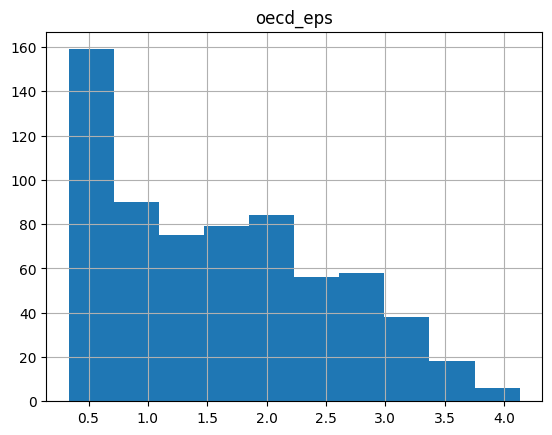

In [7]:
#histogram and skewness
df_s.hist(column='oecd_eps')
print("Skewness oecd_eps: ")
print(skew(df_s['oecd_eps'], nan_policy='omit'))

In [8]:
#Spatial distribution
df_map = df_s.groupby(['ccodealp']).mean()
df_map.reset_index(inplace=True)
df_map = df_map.rename(columns = {'index':'ccodealp'})
fig = px.choropleth(df_map, locations='ccodealp',
                    locationmode='ISO-3',
                    color='oecd_eps', 
                    hover_name='ccodealp',
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

C:\Users\dovile.meskauskaite\AppData\Local\Temp\ipykernel_18976\1777655725.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



C:\Users\dovile.meskauskaite\AppData\Local\Temp\ipykernel_18976\837354285.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



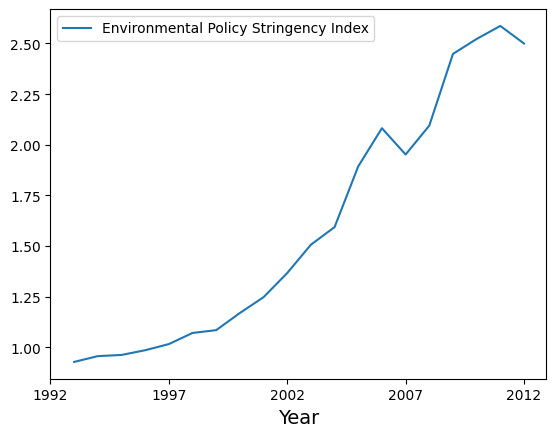

In [9]:
#Distribution over time
df_line = df_s.groupby(['year']).mean()
df_line.reset_index(inplace=True)
df_line = df_line.rename(columns = {'index':'ccodealp'})
plt.plot(df_line['year'], df_line['oecd_eps'], label = "Environmental Policy Stringency Index")
plt.xlabel('Year', fontsize=14)
plt.xticks(np.arange(1992, 2013, 5))
plt.legend()
plt.show()

3.2 Explanatory variable: Average yearly temperature

The average yearly temperature is a continuous variable taking values from -7.4 and 26.4 within the sample selected.

The mean is 10.7°C with a very close median 10.14°C.

Observations:

- Histogram and table: The data are pretty symmetric with a density in the middle of the distribution and a set of small values (Canada and Russia).
- Map: Average temperature is highly related to distance to the equator (no surprise here). Even if the result is obvious here, I find always useful to check that we have what we expect. It allows spotting anomalies or issues with how the different datasets have been merged sometimes.
- Line graph: Overall there is also a positive trend. Almost a two-degree change over two decades. There are two drops in temperature in 1993 and 1996. Also something I would investigate later to understand if some countries are driving this.

In [10]:
df_s['cckp_temp'].describe()

count    663.000000
mean      10.686664
std        7.445290
min       -7.433333
25%        7.458333
50%       10.141667
75%       13.729167
max       26.375000
Name: cckp_temp, dtype: float64

Skewness for cckp_temp: 
0.07896144264298412


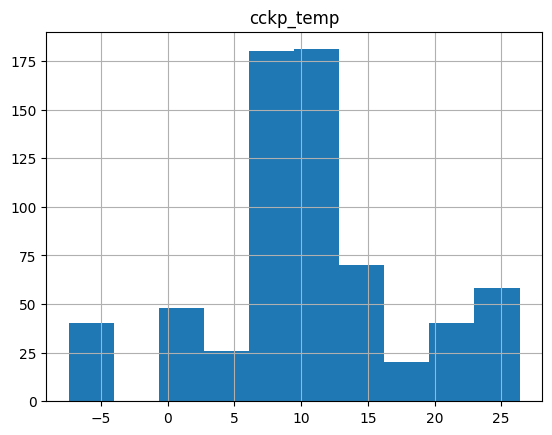

In [11]:
#histogram and skewness
df_s.hist(column='cckp_temp')
print("Skewness for cckp_temp: ")
print(skew(df_s['cckp_temp'], nan_policy='omit'))

In [12]:
# Which countries have average temperature below -2.5?
df_s[df_s['cckp_temp'] < -2.5]['cname'].unique()

array(['Canada', 'Russia'], dtype=object)

In [13]:
#Spatial distribution
df_map = df_s.groupby(['ccodealp']).mean()
df_map.reset_index(inplace=True)
df_map = df_map.rename(columns = {'index':'ccodealp'})
fig = px.choropleth(df_map, locations='ccodealp',
                    locationmode='ISO-3',
                    color='cckp_temp', 
                    hover_name='ccodealp',
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

C:\Users\dovile.meskauskaite\AppData\Local\Temp\ipykernel_18976\1526116129.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



C:\Users\dovile.meskauskaite\AppData\Local\Temp\ipykernel_18976\813141552.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



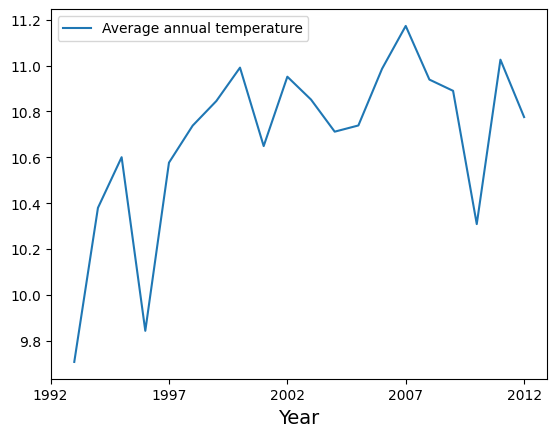

In [14]:
#Distribution over time
df_line = df_s.groupby(['year']).mean()
df_line.reset_index(inplace=True)
df_line = df_line.rename(columns = {'index':'ccodealp'})
plt.plot(df_line['year'], df_line['cckp_temp'], label = "Average annual temperature")
plt.xlabel('Year', fontsize=14)
plt.xticks(np.arange(1992, 2013, 5))
plt.legend()
plt.show()

Additional explanatory variable: Average yearly rainfall

The average yearly rainfall is a continuous variable taking values from 28mm and 281mm within the sample selected.

The mean is 76.8 mm with a median slightly lower 63.2 mm.

Observations:

- Histogram and table: The data are positively skewed with a skewness of 2. I would not at this stage log-transform the data for two main reasons: a) The asymmetry is ‘acceptable’ (rule of thumb is if the skewness is between -3 and 3), b) It will make the interpretation (keeping it in mm) and comparison simpler (the other main explanatory variable is also in level). If you are not familiar with the idea of log transformation for skewed data, you can refer to this article.
- Map: Indonesia is an “outlier”. To say the least, it has clearly the highest values of rainfall. This variable will be used to see if the effect (of temperature on environmental policies) is different when there is a lot versus little rainfall. Hence, as I will dichotomize (above/below median) the rainfall variable for the heterogeneity exercise later, an outlier will not affect the analysis.
- Line graph: The time trend is relatively noisy.

In [15]:
df_s['cckp_rain'].describe()

count    663.000000
mean      76.825842
std       41.994952
min       28.183333
25%       49.870833
50%       63.166667
75%       92.204167
max      281.100000
Name: cckp_rain, dtype: float64

Skewness for cckp_rain: 
2.067542872406307


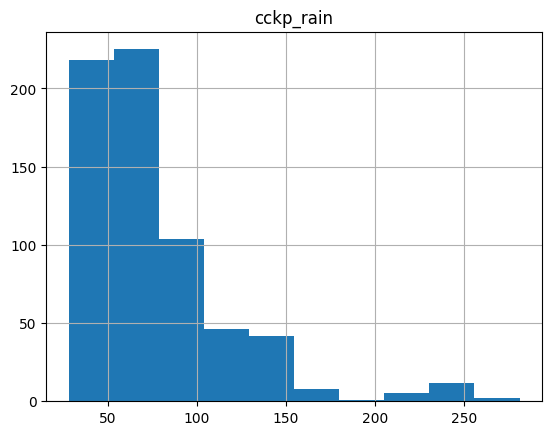

In [16]:
df_s.hist(column='cckp_rain')
print("Skewness for cckp_rain: ")
print(skew(df_s['cckp_rain'], nan_policy='omit'))

In [17]:
#Spatial distribution
df_map = df_s.groupby(['ccodealp']).mean()
df_map.reset_index(inplace=True)
df_map = df_map.rename(columns = {'index':'ccodealp'})
fig = px.choropleth(df_map, locations='ccodealp',
                    locationmode='ISO-3',
                    color='cckp_rain', 
                    hover_name='ccodealp',
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

C:\Users\dovile.meskauskaite\AppData\Local\Temp\ipykernel_18976\405132515.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



C:\Users\dovile.meskauskaite\AppData\Local\Temp\ipykernel_18976\1238207731.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



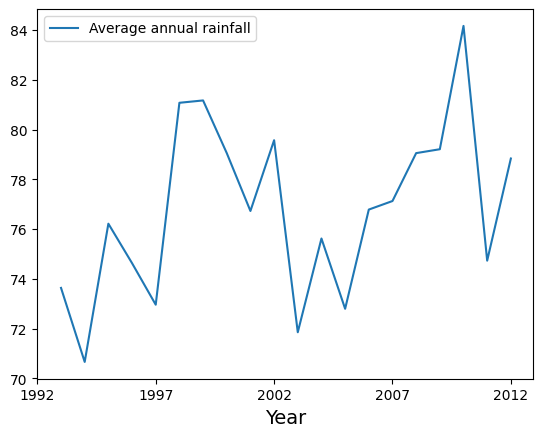

In [18]:
#Distribution over time
df_line = df_s.groupby(['year']).mean()
df_line.reset_index(inplace=True)
df_line = df_line.rename(columns = {'index':'ccodealp'})
plt.plot(df_line['year'], df_line['cckp_rain'], label = "Average annual rainfall")
plt.xlabel('Year', fontsize=14)
plt.xticks(np.arange(1992, 2013, 5))
plt.legend()
plt.show()

In [31]:
# Create a binary variable taking the value one if the country is above median (wrt rainfall). This is for the heterogeneity exercise later

df_s.loc[df_s['cckp_rain'] > df_s['cckp_rain'].median(), 'cckp_rain']
df_s['cckp_rain_bin'].astype(int)


554      0
555      0
556      0
557      0
558      0
        ..
11034    0
11035    0
11036    0
11037    0
11038    0
Name: cckp_rain_bin, Length: 663, dtype: int32

4. Bivariate analysis

Text(0, 0.5, 'Environmental Policy Stringency Index')

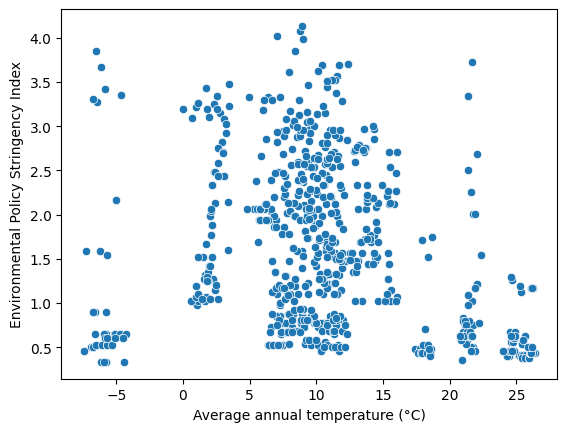

In [32]:
#Simple scatter plot
sns.scatterplot(x='cckp_temp', y='oecd_eps', data=df_s)
plt.xlabel('Average annual temperature (°C)')
plt.ylabel('Environmental Policy Stringency Index')

Observations: It seems that the dots are spread in small groups vertically. I guess that the average annual temperature have higher between-country variation than within-country. Hence, it makes more sense for the analysis to look at how within-country variations in temperature are associated with the outcome. To confirm this idea I will simply plot the same graph while coloring the dots by countries.

Text(0, 0.5, 'Environmental Policy Stringency Index')

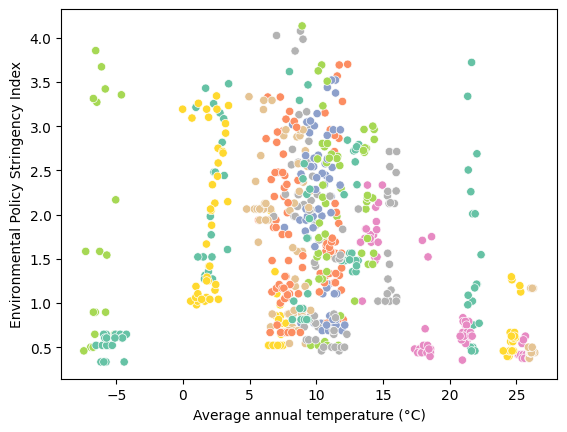

In [33]:
#Scatter plot coloring the dots by countries
sns.scatterplot(x='cckp_temp', y='oecd_eps', legend=False, hue='ccodealp', palette='Set2', data=df_s)
plt.xlabel('Average annual temperature (°C)')
plt.ylabel('Environmental Policy Stringency Index')

Observation: Indeed the temperature is relatively stable over time, while there is significant variation for the stringency index within-country.

Hence, let us compute the difference from the mean for the temperature variable for each country rather than using the level (within-country variation).

Text(0, 0.5, 'Environmental Policy Stringency Index')

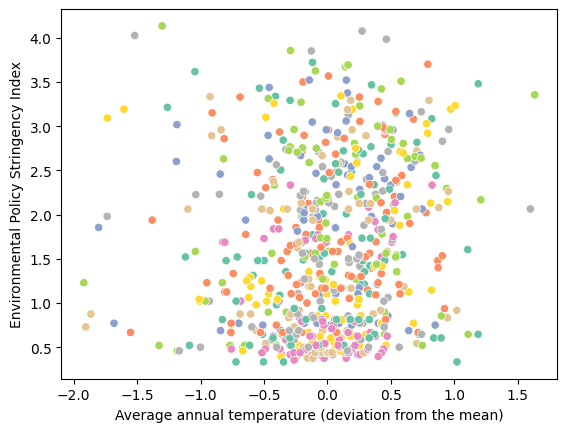

In [34]:
#Computing the within country deviation from the mean for the temperature
df_mean = df_s.groupby('ccodealp')['cckp_temp'].mean().to_frame()
df_mean.columns = ['cckp_temp_mean']
df_s = pd.merge(df_s, df_mean,  how = 'left', left_on = ['ccodealp'], right_on = ['ccodealp'])
df_s['cckp_temp_dm'] = df_s['cckp_temp']-df_s['cckp_temp_mean']
#Redoing the scatter plot with the within country deviation from the mean and coloring by country
sns.scatterplot(x='cckp_temp_dm', y='oecd_eps', legend=False, hue='ccodealp', palette='Set2', data=df_s)
plt.xlabel('Average annual temperature (deviation from the mean)')
plt.ylabel('Environmental Policy Stringency Index')

In [35]:
#Correlation coefficient
df_s[['cckp_temp_dm', 'oecd_eps']].corr()

,cckp_temp_dm,oecd_eps
cckp_temp_dm,1.000000,0.124348
oecd_eps,0.124348,1.000000


Observation: The relationship is clearer and as expected it is positive.

Next? Heterogeneity: Now let’s look if there is some heterogeneity with respect to rainfall.

Text(0, 0.5, 'Environmental Policy Stringency Index')

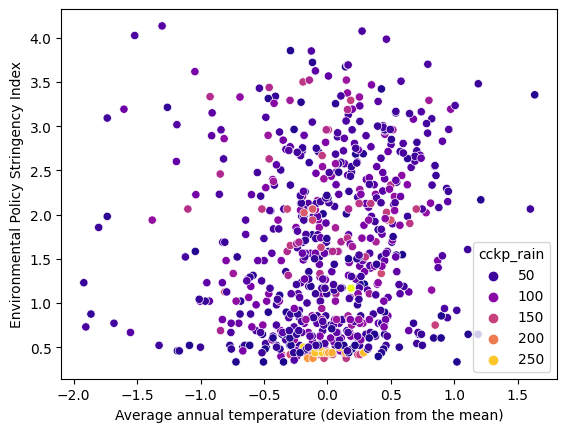

In [36]:
#Scatter plot with coloring based on rainfall
sns.scatterplot(x='cckp_temp_dm', y='oecd_eps',  hue='cckp_rain', palette='plasma', data=df_s)
plt.xlabel('Average annual temperature (deviation from the mean)')
plt.ylabel('Environmental Policy Stringency Index')

Observation: Visually the relationship is unclear. However, the countries with the highest rain seem to have a low-temperature variation and low environmental policy stringency index (potentially Indonesia).

Let’s do a sample split to explore the relationship between temperature and environmental policy stringency index for countries with rainfall above versus below median (heterogeneity exercise).

In [37]:
#Correlation for each sub sample below median rainfall
tmp = df_s[df_s['cckp_rain_bin']==0]
tmp[['cckp_temp_dm', 'oecd_eps']].corr()

,cckp_temp_dm,oecd_eps
cckp_temp_dm,1.000000,0.190651
oecd_eps,0.190651,1.000000


In [38]:
#Correlation for each sub sample above median rainfall
tmp = df_s[df_s['cckp_rain_bin']==1]
tmp[['cckp_temp_dm', 'oecd_eps']].corr()

,cckp_temp_dm,oecd_eps
cckp_temp_dm,1.000000,0.036122
oecd_eps,0.036122,1.000000


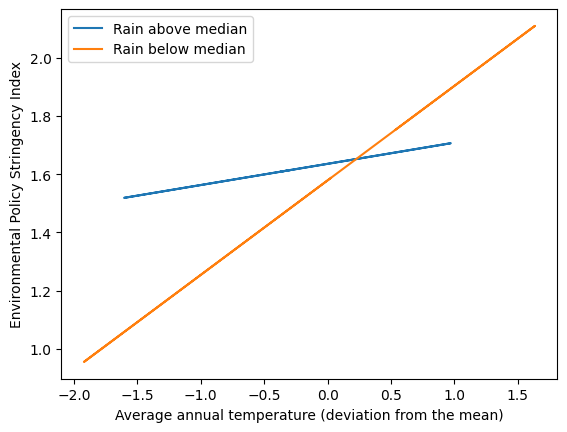

In [39]:
#Plot the best fit line for the two subsamples: below/above median rain.
df_0 = df_s[df_s['cckp_rain_bin']== 0]
df_1 = df_s[df_s['cckp_rain_bin']== 1]
a, b = np.polyfit(df_1['cckp_temp_dm'], df_1['oecd_eps'], 1)
plt.plot(df_1['cckp_temp_dm'], a*df_1['cckp_temp_dm']+b, label='Rain above median')
a, b = np.polyfit(df_0['cckp_temp_dm'], df_0['oecd_eps'], 1)
plt.plot(df_0['cckp_temp_dm'], a*df_0['cckp_temp_dm']+b, label='Rain below median')
plt.xlabel('Average annual temperature (deviation from the mean)')
plt.ylabel('Environmental Policy Stringency Index')
plt.legend()

Observation: The correlation between environmental policy and temperature (deviation from the mean) is positive. The correlation is almost zero for the sample with rain above median (0.036) while it is relatively large for the sample below median (0.19). From the last graph, we can see that the slope of the linear fit is steeper for the sample with low rain but the intercept is lower. It would be heroic to conclude anything from those simple preliminary graphs. However, it suggests some potential interesting heterogeneity. This is as far as I will go with the descriptive statistics (already more than a bivariate analysis by the way).

5. Conclusion

There is a positive association between (within-country) temperature variation and environmental policy stringency index (for OECD countries from 1993 to 2012).
The relationship is strongly reinforced for observations experiencing low rain during the same year.
From this simple heterogeneity exercise, it remains unclear if this association is stronger for countries where there is little rain on average (e.g.: Australia, Spain, or South Africa) or for any country during drier years (e.g.: France in 2003).
Next: I would now refine this exercise and in particular look into three things: 1. What happened in 2007 with the drop in the stringency index (one country, all countries, and understand why), 2. Explore also which regions are driving the aggregated drop in temperature in 1998 and 2010 (it could lead to an interesting event study). 3. Use an event study to inspect if the effect takes place solely the same year, or with lags etc. Then, depending on the findings, I would fit a multivariate model to quantify the effect and control for confounders.